## HOMEWORK 5
This homework will look at image linear registration and its use in digital photography

# Problem 1:
If you can't do this (or don't want to), I am giving data files you can use.  I just thought it would be more fun to use your own.

Go out and enjoy the last few days of nice weather before it starts to get cold!
Using your phone (or whatever), collect a set of images that we will use in this homework set.  

* (1) Pick something that has distinct features and take several (5 is good) pictures of this from slightly different angles.  The images should have about 50% overlap (or more) with the one before it.  We are going use these to do image stitching to make a panorama.

* (2) [If possible] Pick an object that has alot of light-dark contrast.  For example, a dimly lit room, or in shadows, or outside where the sun is really bright.  Take a set of images with the same view with different exposures (it might be good to prop the camera/phone to help keep it steady).  We are going to use this to do High Dynamic Range Imaging (HDRI)

On newer iPhone (14+) you can do this in the camera app.  Android phones allow this in "professional" or "manual" mode of the camera app.  Or there are a bunch of free camera apps.





# Problem 2:
Using two of the images you took from part (1) above:

* Calculate features from both images using the cv2.goodFeaturesToTrack function.  
Use the 25_VideoMotionCorrection.ipynb (Lecture 12; LectureNotebooks Git) as a demo.

* Display the total features found on both images 

* Apply the feature matching code and display the matched features between the two images (see lecture 11 notebooks)

* Finally, warp the moveable image and display (in calculating the registration, you set one image as the target and one as 
the moveable based on the order you gave them in the function call). 

Image 1 Total Features: 200
Image 2 Total Features: 200


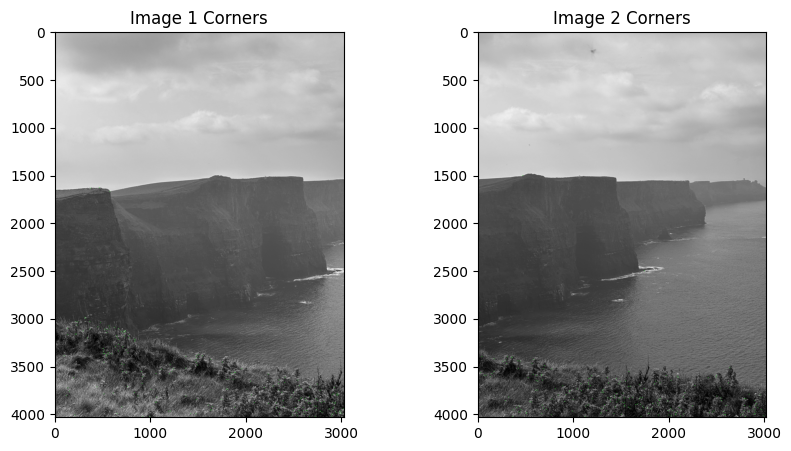

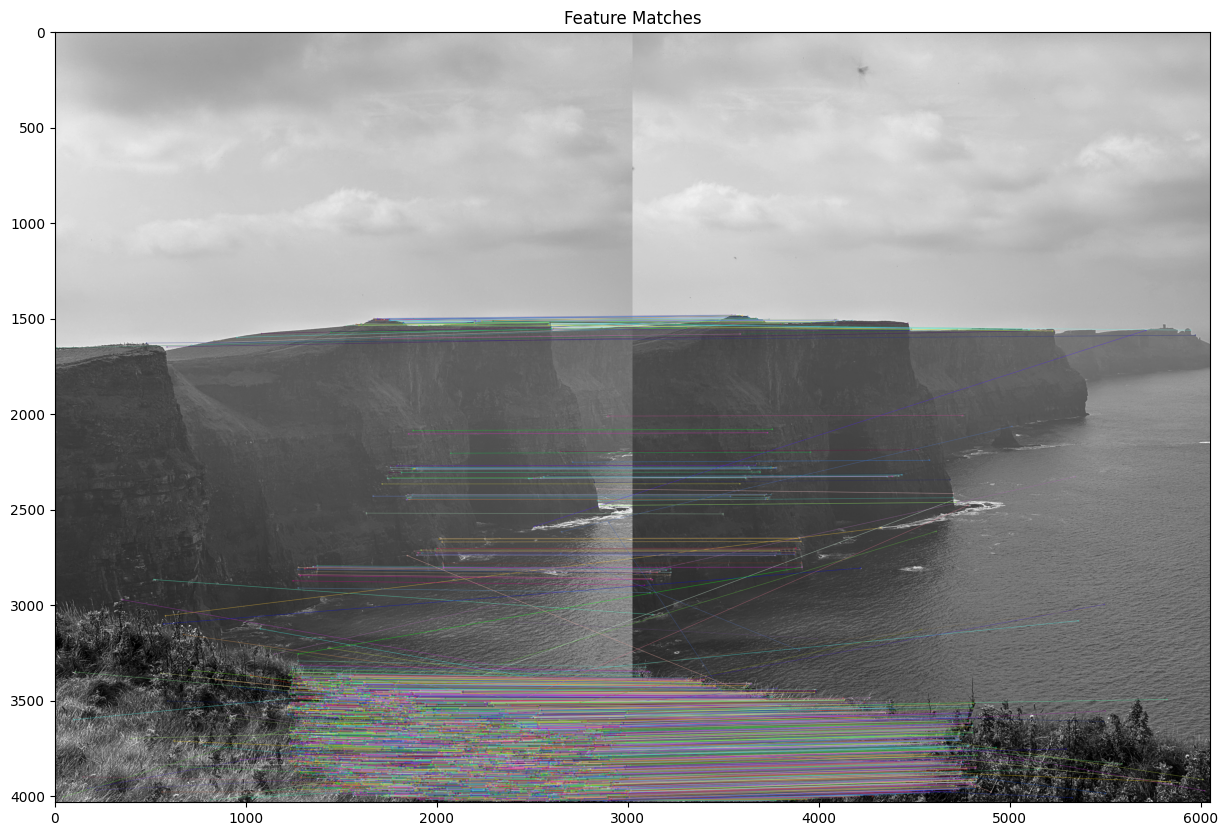

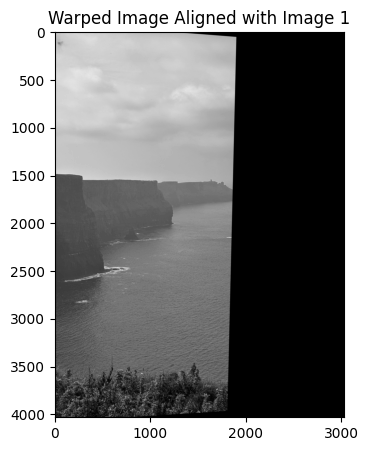

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两张图像
img1 = cv2.imread('Data/Moher/Cliffs_of_Moher - 1.jpeg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('Data/Moher/Cliffs_of_Moher - 2.jpeg', cv2.IMREAD_GRAYSCALE)

# 使用 cv2.goodFeaturesToTrack 检测角点特征
corners1 = cv2.goodFeaturesToTrack(img1, maxCorners=200, qualityLevel=0.01, minDistance=10)
corners2 = cv2.goodFeaturesToTrack(img2, maxCorners=200, qualityLevel=0.01, minDistance=10)

# 显示检测到的角点数量
print(f"Image 1 Total Features: {len(corners1)}")
print(f"Image 2 Total Features: {len(corners2)}")

# 在图像中标记角点
img1_with_corners = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_with_corners = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

for corner in corners1:
    x, y = corner.ravel()
    cv2.circle(img1_with_corners, (int(x), int(y)), 3, (0, 255, 0), -1)

for corner in corners2:
    x, y = corner.ravel()
    cv2.circle(img2_with_corners, (int(x), int(y)), 3, (0, 255, 0), -1)

# 使用 matplotlib 显示带有角点的图像
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1_with_corners, cv2.COLOR_BGR2RGB))
plt.title('Image 1 Corners')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2_with_corners, cv2.COLOR_BGR2RGB))
plt.title('Image 2 Corners')

plt.show()

# 使用 SIFT 进行特征检测和描述
sift = cv2.SIFT_create()
keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(img2, None)

# 使用 BFMatcher 进行特征匹配
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptor1, descriptor2, k=2)

# 应用比例测试
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append([m])

# 显示匹配结果
img_matches = cv2.drawMatchesKnn(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Feature Matches')
plt.show()

# 提取匹配的关键点坐标
no_of_matches = len(good_matches)
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

for i in range(no_of_matches):
    p1[i, :] = keypoints1[good_matches[i][0].queryIdx].pt
    p2[i, :] = keypoints2[good_matches[i][0].trainIdx].pt

# 计算单应性矩阵（基于比例测试后的匹配）
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# 使用单应性矩阵进行图像变换
transformed_img = cv2.warpPerspective(img2, homography, (img1.shape[1], img1.shape[0]))

# 使用 matplotlib 显示变换后的图像
plt.figure(figsize=(10, 5))
plt.imshow(transformed_img, cmap='gray')
plt.title('Warped Image Aligned with Image 1')
plt.show()


# Problem 3
Using all the images you took in (1) of problem 1, we will not make a panorama.  This is basically the same thing 
you did for problem 2, but done iteratively to align all the images with each other.  Of course, there is a function in
openCV for this.   

stitcher=cv2.Stitcher.create()

(dummy,output)=stitcher.stitch(img_list) 

Note- I would not use more than 5 images because the sticher can take a bit of time if you have a lot 


Successfully loaded 5 images.
Panorama stitching successful.


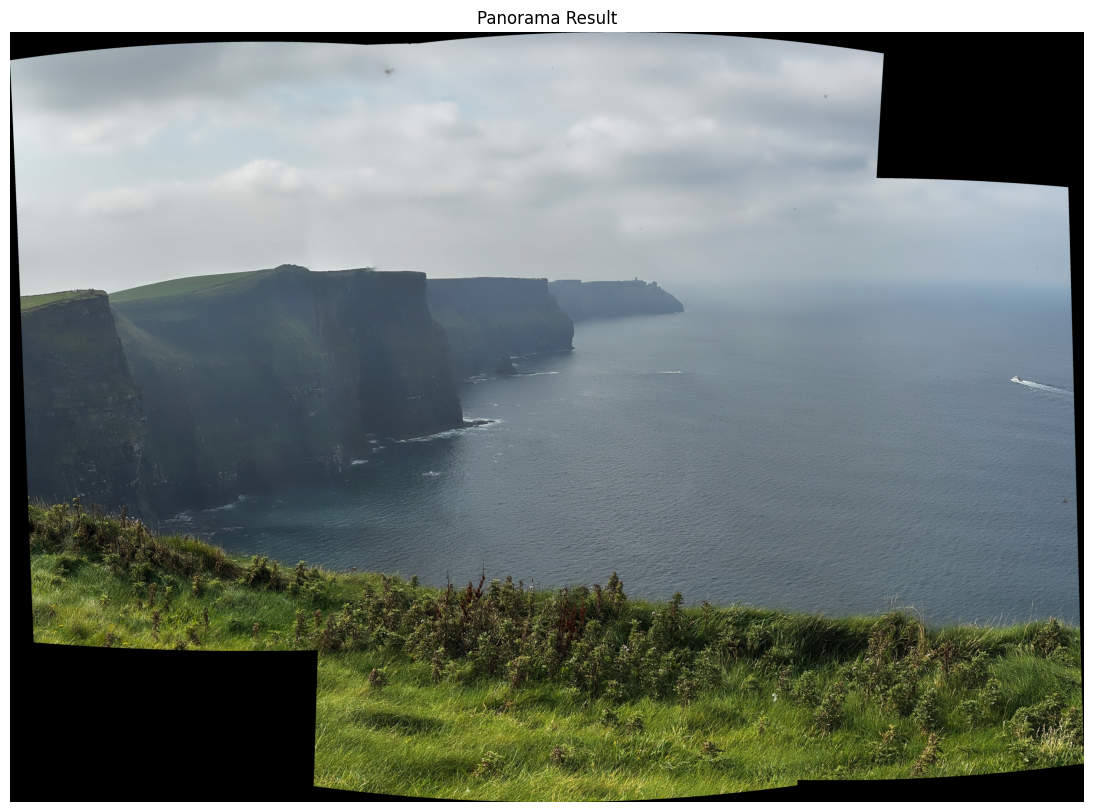

In [25]:
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 使用 glob 模块获取图像文件列表
# 请替换为你自己的图像文件路径
img_filenames = glob.glob(os.path.relpath("Data/Moher/Cliffs_of_Moher - *.jpeg"))
img_filenames = sorted(img_filenames)  # 排序图像文件名

# 读取所有图像并将它们存储在列表中
img_list = [cv2.imread(file) for file in img_filenames]

# 检查图像是否成功读取
if len(img_list) == 0:
    print("No images found, please check your file path.")
else:
    print(f"Successfully loaded {len(img_list)} images.")

# 将图像转换为 RGB 颜色空间（OpenCV 默认是 BGR）
img_list = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in img_list]

# 使用 OpenCV 的拼接器进行图像拼接
stitcher = cv2.Stitcher.create()

# 拼接图像
(status, output) = stitcher.stitch(img_list)

# 检查拼接状态
if status == cv2.Stitcher_OK:
    print("Panorama stitching successful.")
    # 显示拼接结果
    plt.figure(figsize=(20, 10))
    plt.imshow(output)
    plt.title('Panorama Result')
    plt.axis('off')
    plt.show()
else:
    print("Panorama stitching failed.")



# Problem 4.
HDRI combines images with multiple exposures in order to increase the dynamic range of the camera (e.g. able to see both dim and bright objects).  

[1390 & 2390 students]
* Using the images from (2) of problem 1, (or use the ones in Data/Trinity_Library) combine your images into one HDR photo and display it

* Use the Mertens function in openCV (e.g)

*           merge_mertens = cv2.createMergeMertens()
*           hdr_img = merge_mertens.process(img_list)

Note, the Mertens function does not need the exposure times to be provided


[1390 & 2390 students]
* For the same images used in the first part of this problem, apply the MTB motion correction and repeat/show the HDR image

*           alignMTB = cv2.createAlignMTB()
*           alignMTB.process(img_list_In,img_list_Out)




[ECE2390 students]
* Repeat HDR method using the Debevec method.  If you use the Trinity_Library images, the exposure times are [1/50s,1/33s,1/25s,1/20s,1/17s] and EV stops are [-2,-1,0,1,2]




Successfully loaded 5 images.


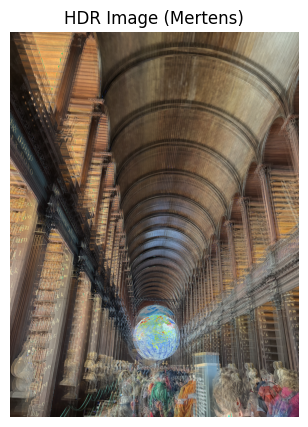

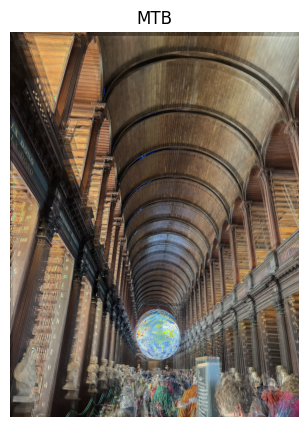

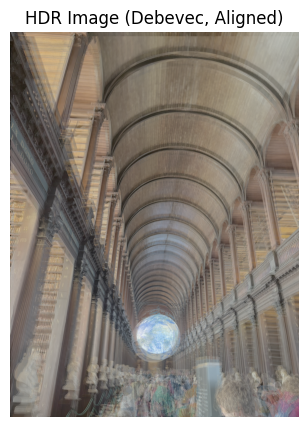

In [32]:
import cv2
import glob
import os
import matplotlib.pyplot as plt

img_filenames = glob.glob(os.path.relpath("Data/Trinity_Library/TrinityLibrary - 0*.jpeg"))
img_filenames = sorted(img_filenames)

img_list = [cv2.imread(file) for file in img_filenames]

img_list = [img for img in img_list if img is not None]
if len(img_list) == 0:
    print("No valid images found, please check your file path.")
else:
    print(f"Successfully loaded {len(img_list)} images.")

merge_mertens = cv2.createMergeMertens()
hdr_mertens = merge_mertens.process(img_list)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor((hdr_mertens * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
plt.title('HDR Image (Mertens)')
plt.axis('off')
plt.show()

alignMTB = cv2.createAlignMTB()
#alignMTB.setMaxBits(6)
alignMTB.process(img_list, img_list) 

hdr_mertens_aligned = merge_mertens.process(img_list)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor((hdr_mertens_aligned * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
plt.title('MTB')
plt.axis('off')
plt.show()

# Exposure time (seconds), corresponding to EV [-2, -1, 0, 1, 2]
exposure_times = np.array([1/50, 1/33, 1/25, 1/20, 1/17], dtype=np.float32)



# Create HDR image using Debevec method 
merge_debevec = cv2.createMergeDebevec()
hdr_debevec = merge_debevec.process(img_list, times=exposure_times)

# Use Tonemap to convert the HDR image to an LDR image for display
tonemap = cv2.createTonemap(gamma=2.2)
ldr_debevec = tonemap.process(hdr_debevec)

# Display Debevec HDR image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor((ldr_debevec * 255).astype('uint8'), cv2.COLOR_BGR2RGB))
plt.title('HDR Image (Debevec, Aligned)')
plt.axis('off')
plt.show()